In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


['/device:CPU:0', '/device:GPU:0']


# 0. Loading the data

### TinyImageNet does not have labels for the testing data. We will use the 10k validation images for the testing data.

In [6]:
from tensorflow.keras.utils import to_categorical  

#load cifar-10 dataset
(X_tot, y_tot), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
#one hot encoding
y_test=to_categorical(y_test, num_classes=100)
y_tot=to_categorical(y_tot, num_classes=100)

print(X_tot.shape)
print(y_tot.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [7]:
#shuffle data and split data to generate validation data
shuffler = np.random.RandomState(seed=42).permutation(len(X_tot))
X_tot = X_tot[shuffler]
y_tot = y_tot[shuffler]
 

#validation data
X_val=X_tot[0:2000]
y_val=y_tot[0:2000]

X_train=X_tot[2000:]
y_train=y_tot[2000:]

# 1. Using ResNet with ImageNet

### We use our custom resnet model generator to get any resnet 

CIFAR 100 has 100 different labels

We use a custom resnet model, because the images are 32x32 we do not need to go as deep to get good results.The CNN layers go to 2x2 resolution instead to 1x1 in a traditional resnet model.

In [4]:
from utils.custom_resnet import custom_resnet
from utils.train_CIFAR_ResNet import cifar_resnet_train
# tinyImageNet_resnet_train(model,path,X_train,y_train,X_val,y_val,data_aug=False,learning_rate=0.6,steps=14,epochs=45,batch_size=128,es_patience=8)
resnet_46=custom_resnet(res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=100)
resnet_46.summary()
#tf.keras.utils.plot_model(resnet_18, to_file='test.png',show_shapes=True)

Model: "custom_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[0][0]                   
______________________________________________________________________________________

## 1.1 Resnet

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt

path='./models/cifar100/resnet_best.hdf5'
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-8 pixel shift max
        height_shift_range=4)#+-8 pixel shift max


reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                              patience=5, min_lr=0.001, verbose=1)

#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=15)
# checkpoints
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_46.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])


train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
step_size_train=train_generator.n//train_generator.batch_size

history=resnet_46.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=200,
                    validation_data=(X_val,y_val),
                    callbacks=[reduce_lr,es,checkpoint])

Epoch 1/200
375/375 [==============================] - 27s 55ms/step - loss: 5.5179 - acc: 0.0398 - val_loss: 3.8718 - val_acc: 0.1210

Epoch 00001: val_acc improved from -inf to 0.12100, saving model to ./models/cifar100/resnet_best.hdf5
Epoch 2/200
375/375 [==============================] - 20s 53ms/step - loss: 3.7441 - acc: 0.1286 - val_loss: 3.6074 - val_acc: 0.1530

Epoch 00002: val_acc improved from 0.12100 to 0.15300, saving model to ./models/cifar100/resnet_best.hdf5
Epoch 3/200
375/375 [==============================] - 20s 52ms/step - loss: 3.3779 - acc: 0.1853 - val_loss: 3.2273 - val_acc: 0.2175

Epoch 00003: val_acc improved from 0.15300 to 0.21750, saving model to ./models/cifar100/resnet_best.hdf5
Epoch 4/200
375/375 [==============================] - 20s 52ms/step - loss: 3.1369 - acc: 0.2301 - val_loss: 3.2999 - val_acc: 0.2250

Epoch 00004: val_acc improved from 0.21750 to 0.22500, saving model to ./models/cifar100/resnet_best.hdf5
Epoch 5/200
375/375 [==============

Epoch 39/200
375/375 [==============================] - 19s 52ms/step - loss: 0.2238 - acc: 0.9363 - val_loss: 2.7310 - val_acc: 0.4995

Epoch 00039: val_acc did not improve from 0.50650
Epoch 40/200
375/375 [==============================] - 20s 52ms/step - loss: 0.2128 - acc: 0.9387 - val_loss: 2.6778 - val_acc: 0.5040

Epoch 00040: val_acc did not improve from 0.50650
Epoch 41/200
375/375 [==============================] - 19s 52ms/step - loss: 0.2026 - acc: 0.9444 - val_loss: 2.7647 - val_acc: 0.5025

Epoch 00041: val_acc did not improve from 0.50650
Epoch 42/200
375/375 [==============================] - 19s 52ms/step - loss: 0.1816 - acc: 0.9516 - val_loss: 2.7045 - val_acc: 0.5040

Epoch 00042: val_acc did not improve from 0.50650
Epoch 43/200
375/375 [==============================] - 19s 52ms/step - loss: 0.1784 - acc: 0.9522 - val_loss: 2.8684 - val_acc: 0.4990

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00043: val_acc did not improve from 0.50650


## Best model weights was saved

Accuracy and loss graphs

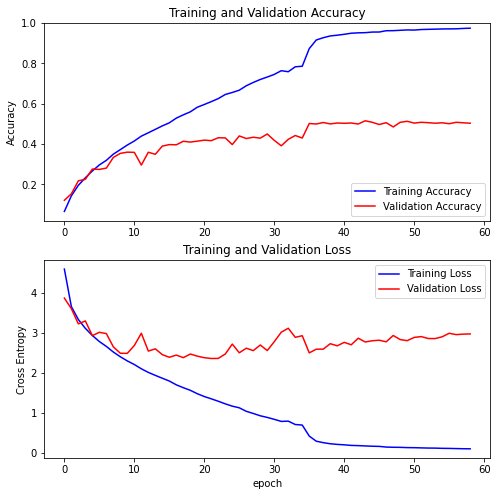

In [6]:
from utils.train_CIFAR_ResNet import plot_model
plot_model(history)


In [9]:
from utils.evaluate_model import score
# reload from saved weights:
model=custom_resnet(res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=100)
model.load_weights(path)

if not os.path.exists('./full_models/cifar100'):
    os.makedirs('./full_models/cifar100')
model.save('./full_models/cifar100/resnet_best.h5')


score(model,X_test,y_test,top_n=[3,5])

313/313 - 3s - loss: 2.7823 - acc: 0.4999
custom_resnet
model accuracy: 49.99%
top 3 accuracy: 69.1100001335144
top 5 accuracy: 76.81999802589417


## 1.2 SE-Resnet

In [9]:
from utils.SE_resnet import SE_custom_resnet

SE_resnet=SE_custom_resnet(res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=100,ratio=16,model_name='custom_resnet46',debug=False)
SE_resnet.summary()

Model: "SE_custom_resnet46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[1][0]                 
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 16, 16, 64)   0           conv1_bn[1][0]                   
_________________________________________________________________________________

In [10]:
path='./models/cifar100/se_resnet_best.hdf5'
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        width_shift_range=4, #+-8 pixel shift max
        height_shift_range=4)#+-8 pixel shift max


reduce_lr = ReduceLROnPlateau(monitor='val_acc', mode='max',factor=0.1,
                              patience=5, min_lr=0.001, verbose=1)

#Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_acc', mode='max', patience=15)
# checkpoints
checkpoint = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
SE_resnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),loss='categorical_crossentropy', metrics = ['acc'])


train_generator = train_datagen.flow(X_train, y_train, batch_size=128)
step_size_train=train_generator.n//train_generator.batch_size

history=SE_resnet.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=200,
                    validation_data=(X_val,y_val),
                    callbacks=[reduce_lr,es,checkpoint])

Epoch 1/200
375/375 [==============================] - 30s 65ms/step - loss: 4.4861 - acc: 0.0668 - val_loss: 3.7179 - val_acc: 0.1475

Epoch 00001: val_acc improved from -inf to 0.14750, saving model to ./models/cifar100/se_resnet_best.hdf5
Epoch 2/200
375/375 [==============================] - 23s 62ms/step - loss: 3.3876 - acc: 0.1907 - val_loss: 3.2866 - val_acc: 0.1995

Epoch 00002: val_acc improved from 0.14750 to 0.19950, saving model to ./models/cifar100/se_resnet_best.hdf5
Epoch 3/200
375/375 [==============================] - 23s 62ms/step - loss: 3.0159 - acc: 0.2535 - val_loss: 3.0727 - val_acc: 0.2620

Epoch 00003: val_acc improved from 0.19950 to 0.26200, saving model to ./models/cifar100/se_resnet_best.hdf5
Epoch 4/200
375/375 [==============================] - 24s 63ms/step - loss: 2.7457 - acc: 0.3048 - val_loss: 2.8240 - val_acc: 0.2995

Epoch 00004: val_acc improved from 0.26200 to 0.29950, saving model to ./models/cifar100/se_resnet_best.hdf5
Epoch 5/200
375/375 [==

## Best model weights was saved

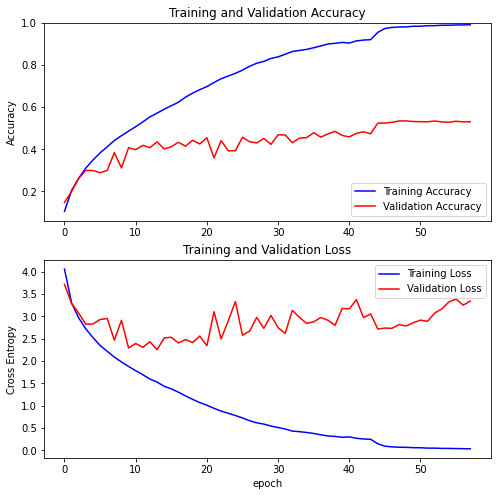

In [11]:
plot_model(history)

In [9]:
from utils.evaluate_model import score
from utils.SE_resnet import SE_custom_resnet
# reload from saved weights:
path='./models/cifar100/se_resnet_best.hdf5'
model=SE_custom_resnet(res_model=[[[3,3],[64,64],4],[[3,3],[128,128],6],[[1,3,1],[256,256,1024],8]],custom_input=(32,32,3),n_classes=100,ratio=16,model_name='custom_resnet46',debug=False)
model.load_weights(path)

model.save('./full_models/cifar100/SE_resnet_best.h5')
del model  # deletes the existing model
model = tf.keras.models.load_model('./full_models/cifar100/SE_resnet_best.h5')

score(model,X_test,y_test,top_n=[3,5])




313/313 - 7s - loss: 2.6477 - acc: 0.5417
SE_custom_resnet46
model accuracy: 54.17%
top 3 accuracy: 72.0300018787384
top 5 accuracy: 79.1599988937378
